<a href="https://colab.research.google.com/github/CJPJ007/HAMMOQ-ASSESSMENT/blob/main/Hammoq_Assessment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 25.36 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [1]:
%cd /content/Mask_RCNN

/content/Mask_RCNN


In [2]:
!pip install tensorflow==1.13.1

In [3]:
!pip install keras==2.0.8

     |████████████████████████████████| 276kB 10.9MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = "/content/Mask_RCNN"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [7]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
!wget https://lp2.hm.com/hmgoepprod?set=quality%5B79%5D%2Csource%5B%2Ff5%2Fc4%2Ff5c4939114fcc731acfada4ebb68f1da42cad909.jpg%5D%2Corigin%5Bdam%5D%2Ccategory%5Bmen_tshirtstanks_shortsleeve%5D%2Ctype%5BDESCRIPTIVESTILLLIFE%5D%2Cres%5Bm%5D%2Chmver%5B1%5D&call=url[file:/product/main]

Processing 1 images
image                    shape: (600, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


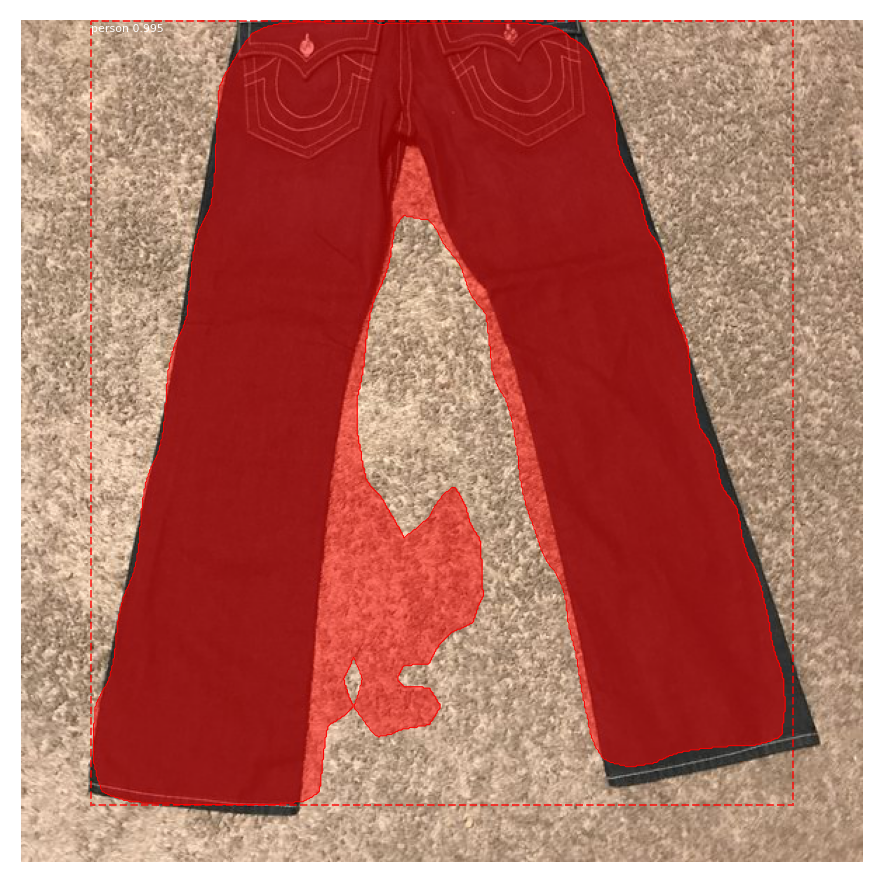

In [82]:
image = skimage.io.imread("/content/sample.jpeg")

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])


In [83]:
new_image=image.copy()
for i in range(3):
    new_image[:,:,i:i+1][r['masks']==False]=255
show_image=np.concatenate((image,new_image),axis=1)

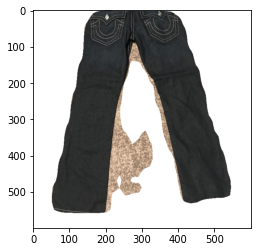

In [84]:
import matplotlib.pyplot as plt
plt.imshow(new_image) 
plt.savefig("sample_1_wb.jpg")

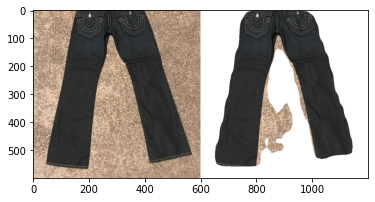

In [85]:
plt.imshow(show_image) 
plt.savefig("sample_1.jpg")

In [88]:
!wget https://previews.123rf.com/images/tsyhun/tsyhun1502/tsyhun150200037/36503645-white-t-shirt-on-wood-background.jpg

--2021-03-18 11:16:12--  https://previews.123rf.com/images/tsyhun/tsyhun1502/tsyhun150200037/36503645-white-t-shirt-on-wood-background.jpg
Resolving previews.123rf.com (previews.123rf.com)... 54.192.86.75, 54.192.86.118, 54.192.86.23, ...
Connecting to previews.123rf.com (previews.123rf.com)|54.192.86.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256540 (251K) [image/jpeg]
Saving to: ‘36503645-white-t-shirt-on-wood-background.jpg’

36503645-white-t-sh 100%[===================>] 250.53K   702KB/s    in 0.4s    

2021-03-18 11:16:13 (702 KB/s) - ‘36503645-white-t-shirt-on-wood-background.jpg’ saved [256540/256540]



Processing 1 images
image                    shape: (1300, 1163, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


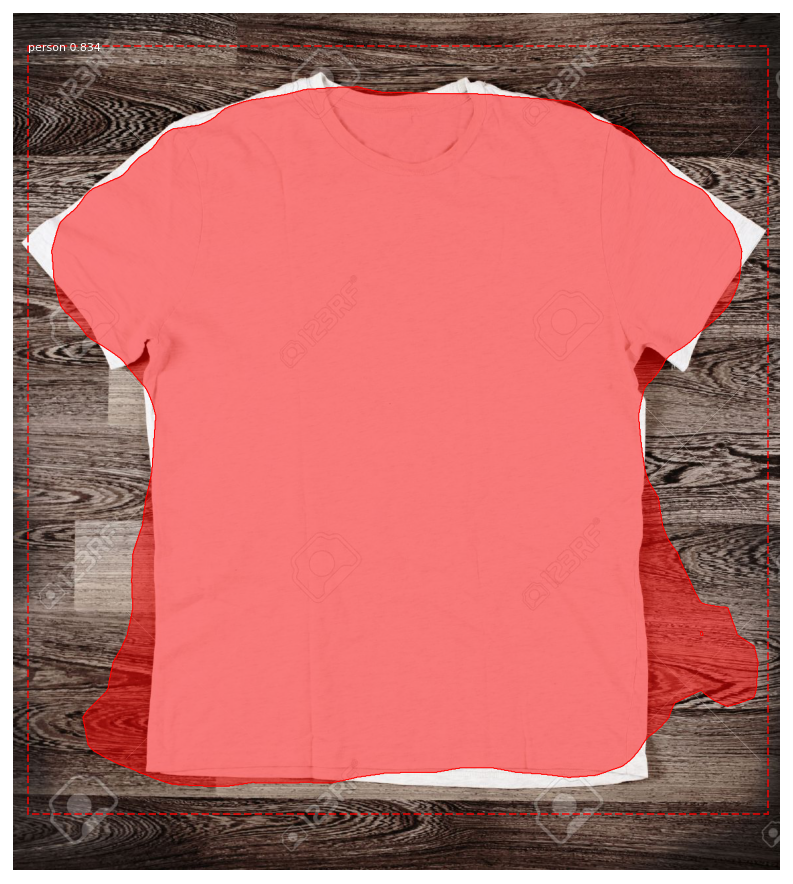

In [89]:
image = skimage.io.imread("/content/Mask_RCNN/36503645-white-t-shirt-on-wood-background.jpg")

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [90]:
new_image=image.copy()
for i in range(3):
    new_image[:,:,i:i+1][r['masks']==False]=255
show_image=np.concatenate((image,new_image),axis=1)

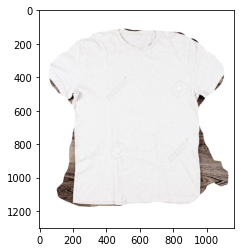

In [91]:
plt.imshow(new_image) 
plt.savefig("sample_2_wb.jpg")

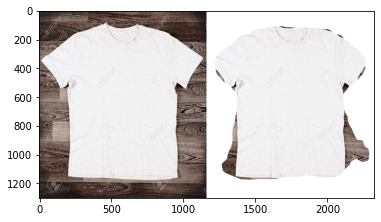

In [92]:
plt.imshow(show_image) 
plt.savefig("sample_2.jpg")

In [ ]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ5UQYIPKbaFeivpRcEQR3_43us9KYYIhy0tg&usqp=CAU

Processing 1 images
image                    shape: (2576, 2576, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2576.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


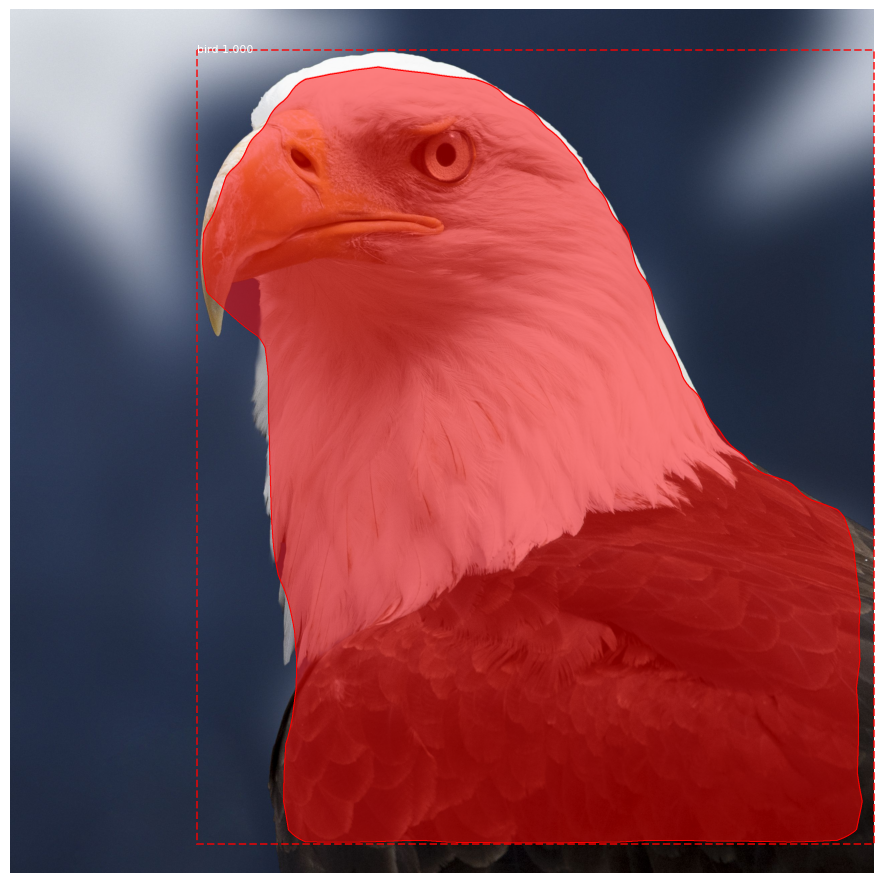

In [100]:
image = skimage.io.imread("/content/american-bald-eagle-head-in-front-of-american-flag-950701786-5b85581346e0fb0025e00b06.jpg")

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [101]:
new_image=image.copy()
for i in range(3):
    new_image[:,:,i:i+1][r['masks']==False]=255
show_image=np.concatenate((image,new_image),axis=1)

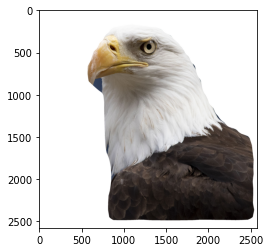

In [102]:
plt.imshow(new_image) 
plt.savefig("sample_3_wb.jpg")

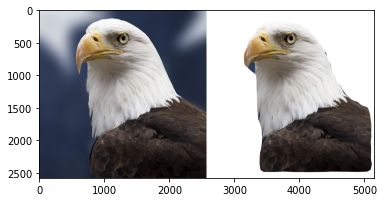

In [103]:
import matplotlib.pyplot as plt
plt.imshow(show_image) 
plt.savefig("sample_3.jpg")